In [1]:
%matplotlib inline

import os, sys, gc
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from tqdm import trange
import time
from scipy import stats
from scipy.stats import shapiro

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from multiprocessing import Pool, Process

import itertools
from modules.kidera import score_positions, score_sequence

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc

In [3]:
# Let's try and train an immunogenicity predicting model on masked peptides

In [4]:
idf1 = pd.read_csv('data/immunogenic_peptides.csv')
anchorpos = pd.read_csv('output/anchorpos.csv')

In [5]:
iedb_mhc = idf1[idf1[' MHC Allele'].str.startswith("HLA")][' MHC Allele'].unique()

In [6]:
sum([x[:4] == 'HLA-' and x[5:][:1] == '*' and x[8:][:1] == ':' for x in iedb_mhc])

94

In [7]:
idf1 = pd.read_csv('data/immunogenic_peptides.csv')
idf2 = pd.read_csv('data/immunogenic_peptides.txt', sep='\t')
idf2 = idf2[idf2['Species']=='Homo']

idf1 = idf1.drop(['Epitope Start', 'Epitope End', ' Epitope Source Organism Name', 'Length'], axis=1)
idf1.columns = ['Peptide', 'MHC', 'Immunogenicity']

# idf2["Species"] = idf2.Peptide.str.len()
idf2 = idf2.drop('Species', axis=1)
idf2.columns = ['Peptide', 'MHC', 'Immunogenicity']

idf1 = idf1.reset_index(drop=True)
idf2 = idf2.reset_index(drop=True)
idf = pd.concat([idf1, idf2], axis=0)
idf.Immunogenicity = idf.Immunogenicity.map({'immunogenic': 1, 'non-immunogenic': 0,
                                             'Positive': 1, 'Negative': 0})
maskdf = idf[idf['Peptide'].str.len()==9]
maskdf = maskdf.drop('MHC', axis=1)
masked = maskdf['Peptide'].apply(lambda x: x[:1] + x[2:8])
maskdf['Masked'] = masked
kidera = maskdf.Masked.apply(lambda s: score_sequence(s))
maskdf = pd.concat([maskdf, kidera], axis=1)
maskdf.head()

,Peptide,Immunogenicity,Masked,1,2,3,4,5,6,7,8,9,10
0,KLEDLERDL,1,KEDLERD,-2.90,2.03,-5.48,6.43,-5.17,-2.11,0.07,0.47,1.02,3.62
1,DLMGYIPLV,1,DMGYIPL,2.31,-1.01,-1.03,-3.26,0.97,-1.59,0.18,1.42,-0.37,0.83
4,LITGRLQSL,1,LTGRLQS,0.20,-2.23,2.10,1.66,-1.91,-3.38,3.35,-2.56,-2.09,0.88
7,AVAKAGKPL,1,AAKAGKP,-1.84,-5.66,-4.75,1.68,1.27,-6.14,3.32,-0.34,-1.25,-0.06
8,AMLQDIATL,1,ALQDIAT,-4.52,-4.18,-0.69,0.13,-2.87,-2.63,-0.71,-1.80,1.70,-3.25


In [8]:
# idf1 = idf.Peptide.apply(lambda s: score_sequence(s))
# idf = pd.concat([idf, idf1], axis=1)
features = ["helix.bend.pref", "side.chain.size",\
        "extended.str.pref", "hydrophobicity", "double.bend.pref", "partial.spec.vol",\
        "flat.ext.pref", "occurrence.alpha.reg", "pK.C", "surrounding.hydrop"]
# idf.head()

In [9]:
X = maskdf[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]].values
y = maskdf['Immunogenicity'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
forest = RandomForestClassifier(100, max_features=None, min_samples_split=3, min_samples_leaf=3,\
                                random_state=42, n_jobs=-1, oob_score=True)
forest.fit(X_train, y_train)
feats_imp = pd.DataFrame(forest.feature_importances_,
                        index=features, 
                        columns=['Importance']).sort_values(['Importance'], 
                                                     ascending=False)
feats_imp

,Importance
hydrophobicity,0.253192
double.bend.pref,0.101203
partial.spec.vol,0.099756
flat.ext.pref,0.087437
helix.bend.pref,0.085595
pK.C,0.078596
side.chain.size,0.074663
occurrence.alpha.reg,0.073729
extended.str.pref,0.073219
surrounding.hydrop,0.072612


In [11]:
clfs = [
    RandomForestClassifier(100, max_features=None, min_samples_split=3, min_samples_leaf=3,
                                random_state=42, n_jobs=-1, oob_score=True),
    GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1),
    SVC(random_state=42, probability=True),
    ExtraTreesClassifier(bootstrap=True, max_features=6, min_samples_leaf=4, 
                                min_samples_split=3, n_estimators=100, n_jobs=-1, oob_score=True, random_state=42)
]

cv = StratifiedKFold(n_splits=10)

for clf in clfs:
    print(type(clf).__name__, np.mean(cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)))

RandomForestClassifier 0.809619021027
GradientBoostingClassifier 0.738245766053
SVC 0.78697745837
ExtraTreesClassifier 0.800847215714


In [12]:
for clf in clfs:
    clf.fit(X=X_train, y=y_train)

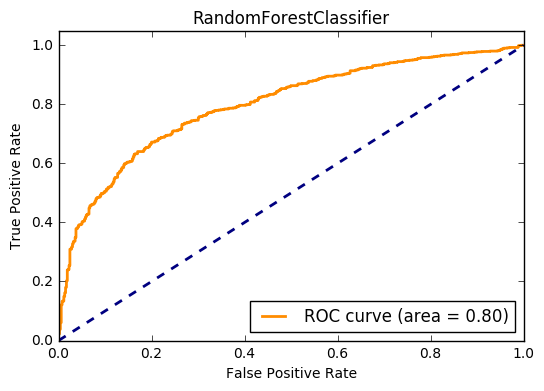

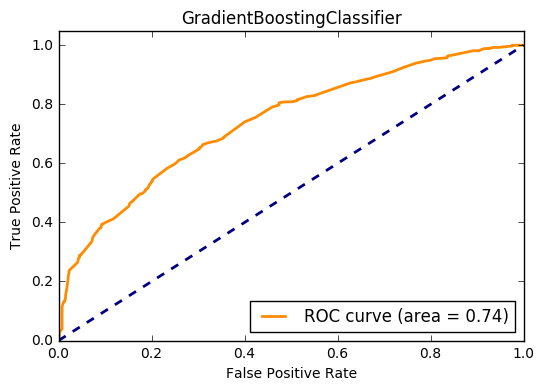

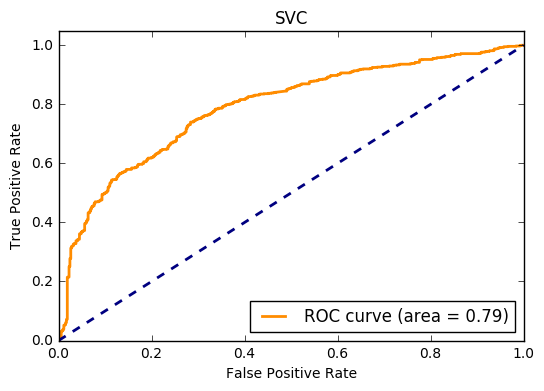

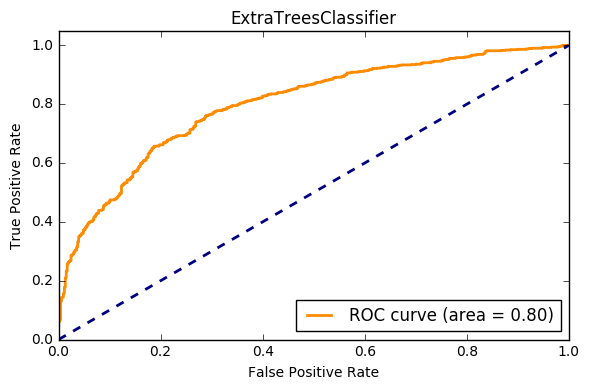

In [13]:
def plot_roc_auc(clf, title):
    y_score = clf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    
names = ["RandomForestClassifier",
         "GradientBoostingClassifier",
         "SVC",
         "ExtraTreesClassifier"]
    
for i in range(len(clfs)):
    plt.figure(figsize=(6, 4))
    plot_roc_auc(clfs[i], names[i])
plt.tight_layout()